In [1]:
from backtester import *
from tqdm.notebook import tqdm_notebook
from fxcmtoken import major_forex_pairs
import os 
import concurrent

In [2]:
for pair in major_forex_pairs:
    print(pair)

EUR/USD
GBP/USD
USD/JPY
USD/CHF
USD/CAD
AUD/USD
NZD/USD


In [3]:
def majorforex_ma_backtest(periods, kind, main_path ,time_frame, plot=False):
    all_portfolios = {}
    all_benchmark = {}
    for file in tqdm_notebook(os.listdir(os.path.join(main_path, time_frame)), leave=False):
        for pair in major_forex_pairs:
            name = pair.replace('/', '_')
            if name in file:
                path = os.path.join(main_path, time_frame, file)
                data = pd.read_csv(path, parse_dates=['date'], index_col=['date'])
                ma_backtest = MovingAverageBacktester(data=data, freq=time_frame, periods=periods, kind=kind)
                ma_backtest.backtest(progress_bar=False)
                if plot is True:
                    print(f"*** {file} ***")
                    ma_backtest.plot_portfolio()
                all_portfolios[pair] = ma_backtest.portfolio_values
                all_benchmark[pair] = ma_backtest.passive_values
    combined_portfolio = None
    combined_benchmark = None
    for port in all_portfolios.values():
        if combined_portfolio is None:
            combined_portfolio = np.array(port)/len(all_portfolios)
        else:
            combined_portfolio += np.array(port)/len(all_portfolios)

    for bench in all_benchmark.values():       
        if combined_benchmark is None:
            combined_benchmark = np.array(bench)/len(all_benchmark)
        else:
            combined_benchmark += np.array(bench)/len(all_benchmark)
    total_backtest = IterativeBacktester(data=None, signals=None, freq='m5')
    total_backtest.periods = periods
    total_backtest.portfolio_values = combined_portfolio
    total_backtest.passive_values = combined_benchmark
    total_backtest.add_returns()
    total_backtest.add_stdevs()
    total_backtest.add_drawdown()
    
    return total_backtest

In [4]:
def backtest_results(backtester):
    periods = backtester.periods
    ret = backtester.returns['Portfolio']['Annualized Return']
    sd = backtester.stdevs['Portfolio']['Annualized Stdev']
    max_dd = backtester.drawdown['Portfolio'].min()
    return (periods ,ret, sd, max_dd)

In [5]:
def majorforex_ma_optim(periods):
    backtester = majorforex_ma_backtest(periods, kind, main_path ,time_frame)
    return backtest_results(backtester)

In [6]:
def parallel_optimzing(periods_list):
    with concurrent.futures.ProcessPoolExecutor() as excecutor:
            results = list(tqdm_notebook(excecutor.map(majorforex_ma_optim, periods_list), total=len(periods_list), leave=False))
    return results
            
def sorting_result(results):    
    results_dict = {}
    for period, ret, sd, max_dd in results:
        results_dict[period] = (ret, sd, max_dd)
    sorted_results = dict(sorted(results_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_results

def log_text_file(sorted_results):
    with open('optim_majorforex.txt', 'a') as file:
        file.write(f'Optimization <{kind}>|<{time_frame}>' + '\n')
        count = 1
        for period, info in sorted_results.items():
            # get top 20
            if count > 20: break
            ret, sd, max_dd = info
            file.write(f"Periods:{period}|Returns:{ret*100:.2f}%|SD:{sd*100:.2f}%|Max_DD:{max_dd*100:.2f}%" + "\n")
            count += 1
        file.write("-"*50 + "\n")

In [8]:
periods_list = []
for short in range(100, 1100, 100):
    for long in range(100, 1100, 100):
        if short < long:
            periods_list.append((short, long))
len(periods_list)        

45

In [15]:
main_path = 'forex_prices'
time_frame = 'm15'
# add more  MA type to backtest
# test with more MA type
# KAMA, WMA
for kind in tqdm_notebook(['SMA', 'EMA', 'KAMA', 'WMA']):
    results = parallel_optimzing(periods_list)
    sorted_results = sorting_result(results)
    log_text_file(sorted_results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

*** AUD_USD_m5.csv ***


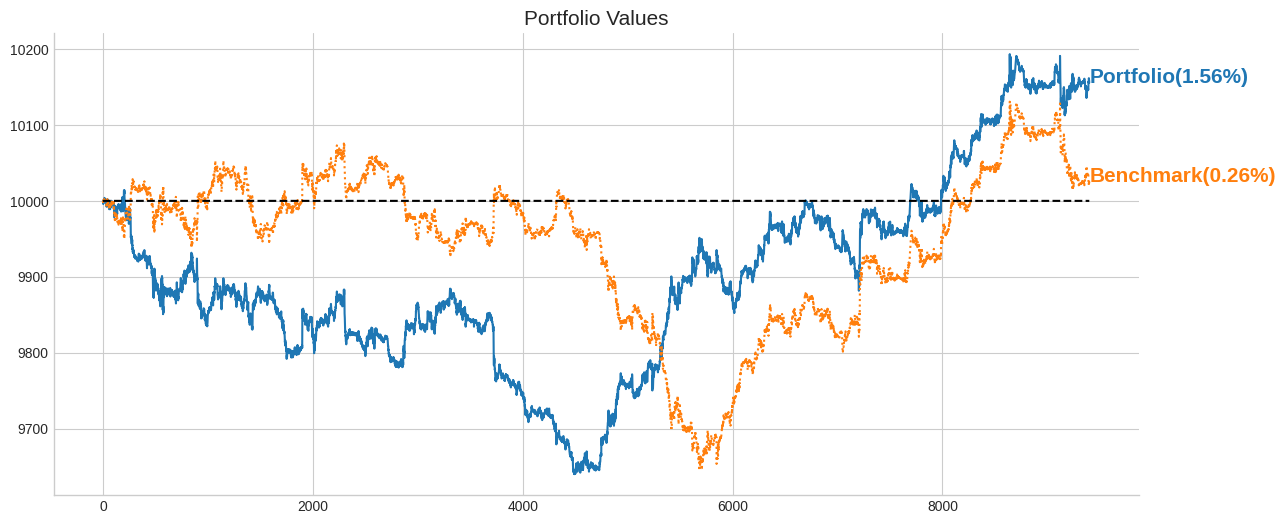

*** USD_JPY_m5.csv ***


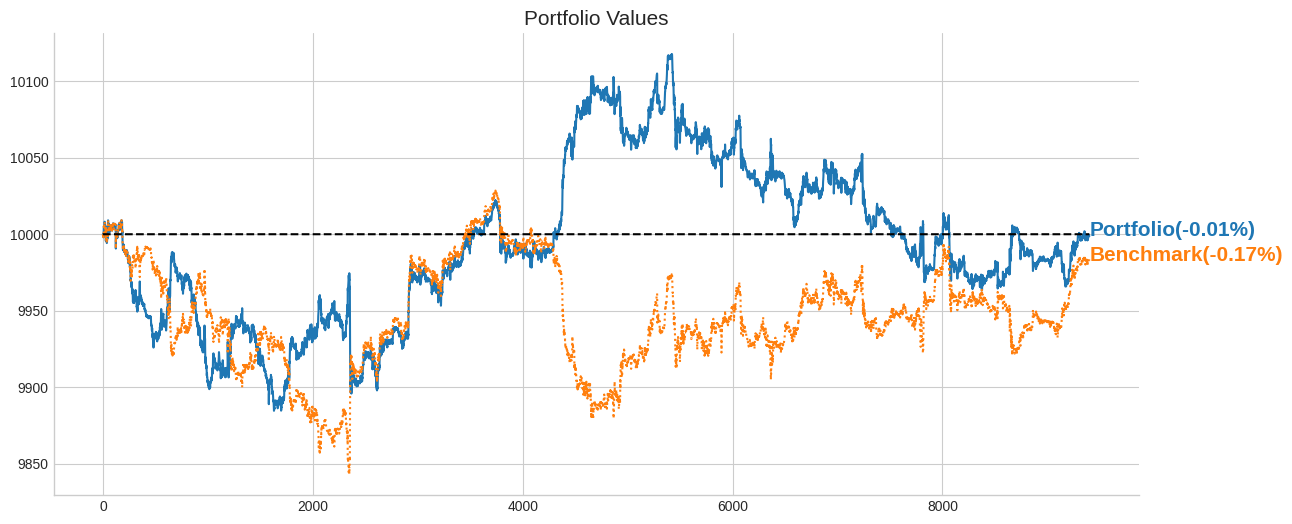

*** USD_CAD_m5.csv ***


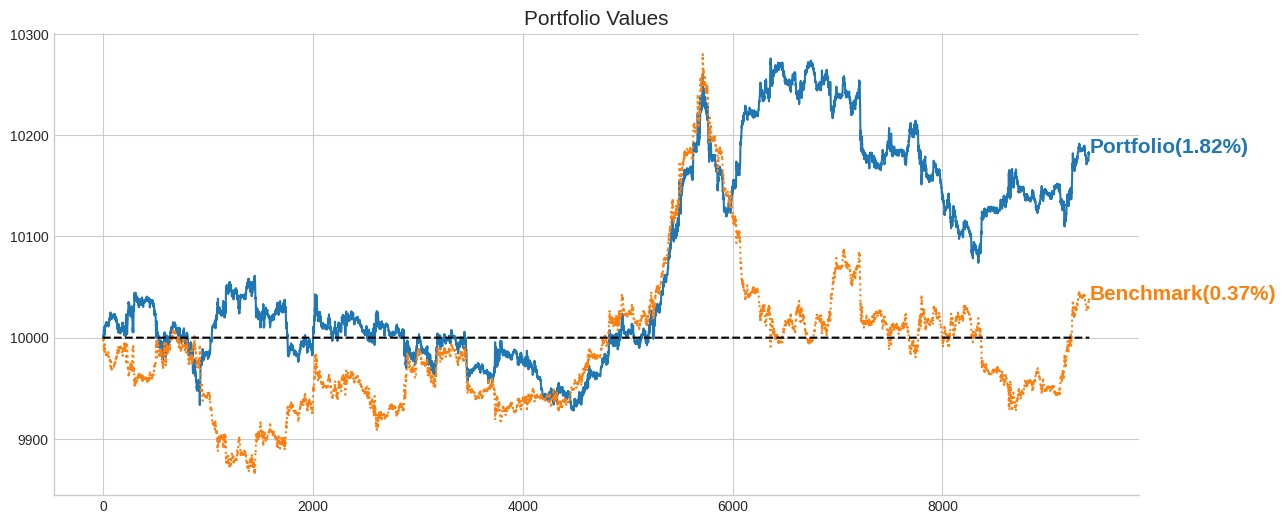

*** USD_CHF_m5.csv ***


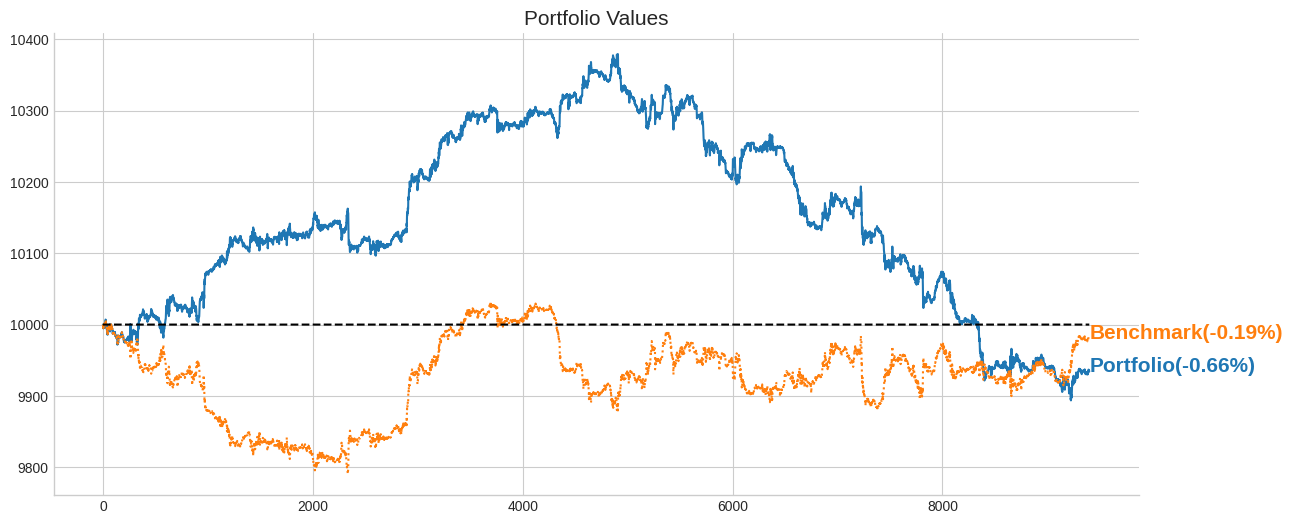

*** NZD_USD_m5.csv ***


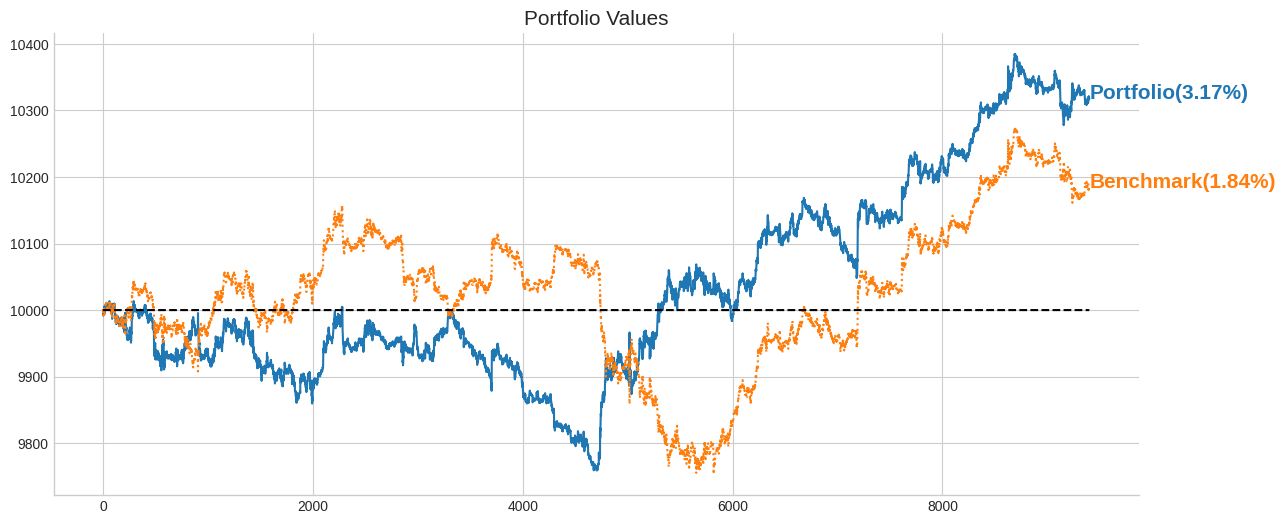

*** GBP_USD_m5.csv ***


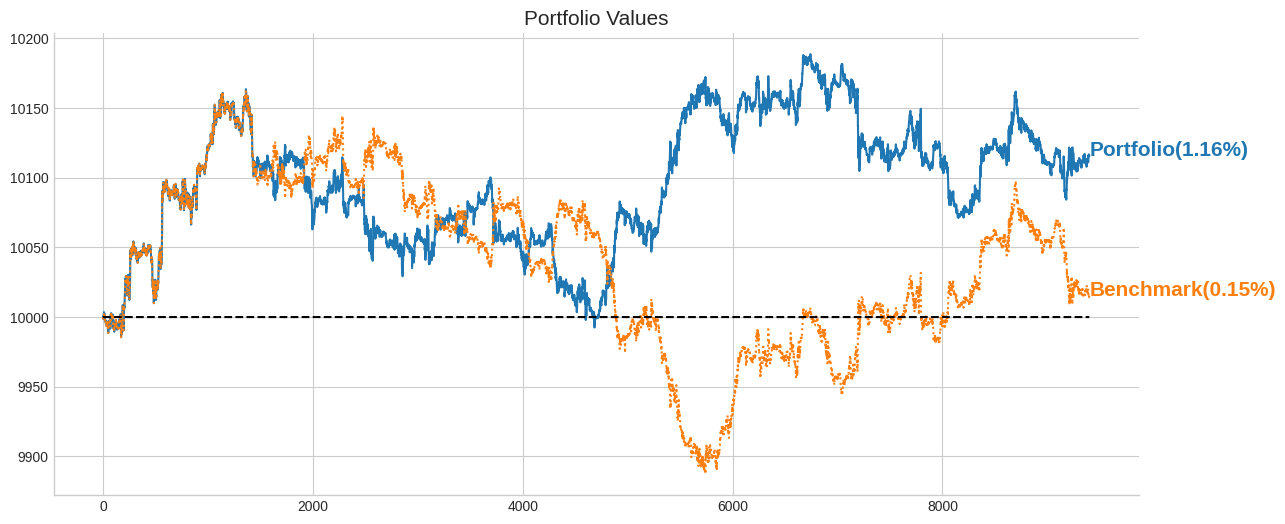

*** EUR_USD_m5.csv ***


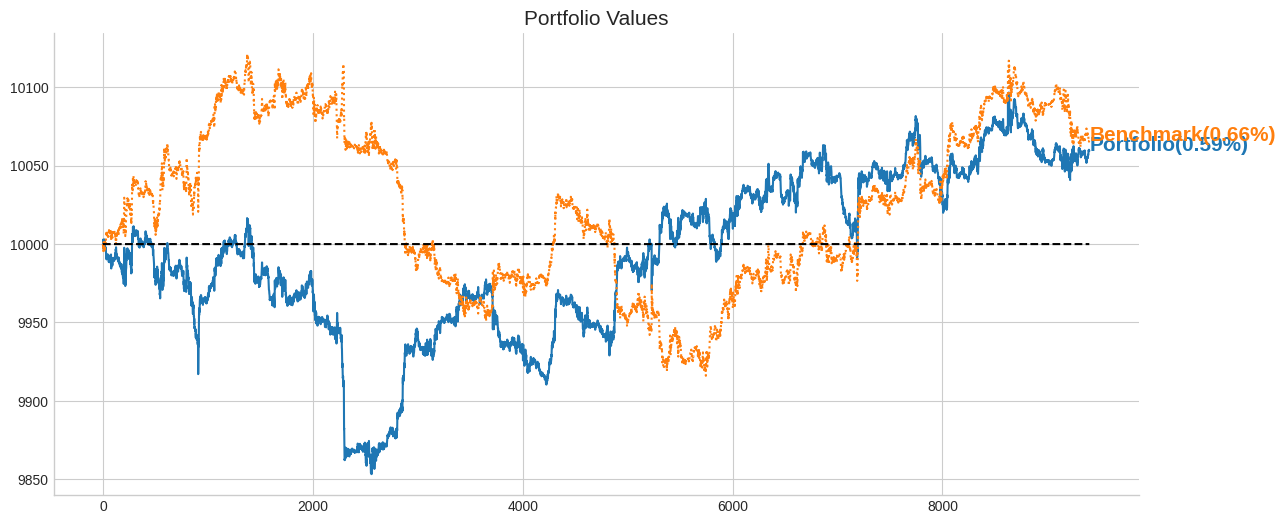

*** Combined Portfolio ***


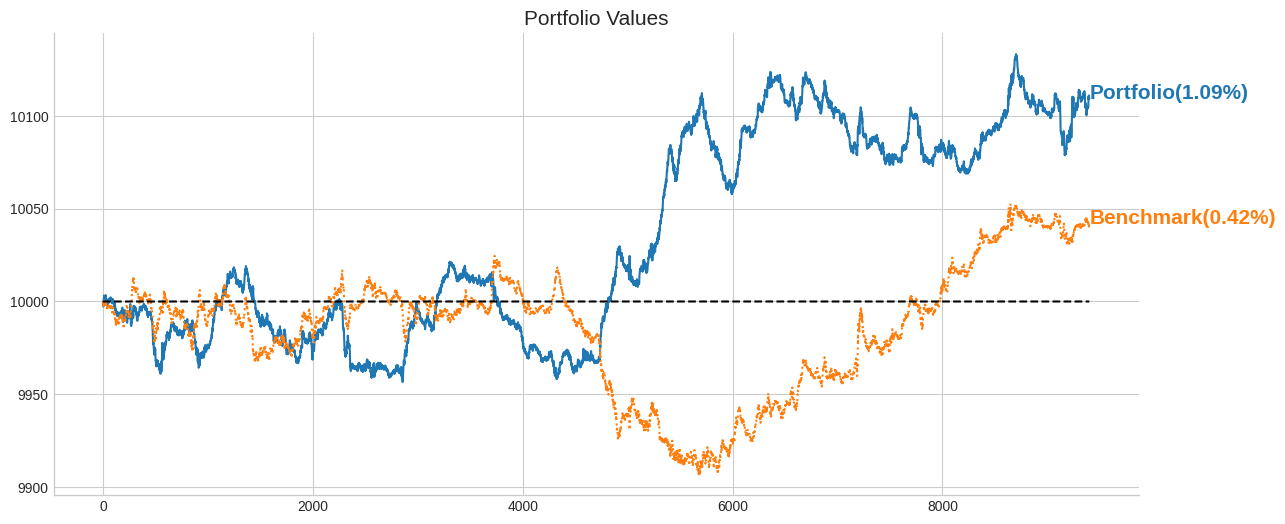

In [8]:
periods = (100, 600)
kind = 'EMA'
main_path = 'forex_prices'
time_frame = 'm5'

backtest = majorforex_ma_backtest(periods, kind, main_path, time_frame, plot=True)
print('*** Combined Portfolio ***')
backtest.plot_portfolio()